# Differential gene expression

Differential gene expression (DGE) analysis identifies genes that show statistically significant differences in expression levels across distinct cell populations or conditions.
This analysis helps in uncovering cellular heterogeneity and understanding the functional roles of specific cell types in health and disease.
Pertpy provides interfaces for 

## Environment setup

Note that the differential gene expression interface requires the `de` extra of pertpy to be installed (`pip install pertpy[de]`).

In [1]:
import anndata as ad
import pertpy as pt

❗ You are running 3.11.4
Only python versions 3.8~3.10 are currently tested, use at your own risk.
💡 connected lamindb: laminlabs/cellxgene


## Dataset

In [2]:
adata = pt.dt.zhang_2021()

Output()

❗ Downloaded and saved to /home/zeth/PycharmProjects/pertpy-tutorials/data/zhang_2021.h5ad


In [9]:
adata.obs.Group

Cell barcode
AAACCTGAGGTTACCT.Pre_P007_b    Pre-treatment
AAACCTGCAAAGGAAG.Pre_P007_b    Pre-treatment
AAACCTGCAAGTCTAC.Pre_P007_b    Pre-treatment
AAACCTGCAATAAGCA.Pre_P007_b    Pre-treatment
AAACCTGCACAGCGTC.Pre_P007_b    Pre-treatment
                                   ...      
TGGTTAGTCACTCTTA.Pre_P004_t    Pre-treatment
TGTTCCGTCTAACGGT.Pre_P004_t    Pre-treatment
TTCGAAGCAATCCAAC.Pre_P004_t    Pre-treatment
TTCTCAATCATCATTC.Pre_P004_t    Pre-treatment
TTCTTAGAGAAGCCCA.Pre_P004_t    Pre-treatment
Name: Group, Length: 489490, dtype: category
Categories (3, object): ['Post-treatment', 'Pre-treatment', 'Progression']

In [ ]:
from pydeseq2.utils import load_example_data

We will use an exampel dataset of raw counts from pydeseq2.
It features two conditions and two groups.

In [2]:
adata = ad.AnnData(
    X=load_example_data(
        modality="raw_counts",
        dataset="synthetic",
        debug=False,
    ),
    obs=load_example_data(
        modality="metadata",
        dataset="synthetic",
        debug=False,
    ),
)

In [3]:
adata.obs

,condition,group
sample1,A,X
sample2,A,Y
sample3,A,X
sample4,A,Y
sample5,A,X
...,...,...
sample96,B,Y
sample97,B,X
sample98,B,Y
sample99,B,X


## EdgeR

```{note}
The edger interface further requires edger to be installed (`BiocManager::install("edgeR")`).
```

In [4]:
edgr = pt.tl.EdgeR(adata, design="~condition")

In [5]:
edgr.fit()
res_df = edgr.test_contrasts(edgr.contrast("condition", "A", "B"))

In [6]:
res_df

,variable,log_fc,logCPM,F,p_value,adj_p_value,contrast
0,gene5,0.611398,16.654136,13.986147,0.000195,0.001045,None
1,gene4,-0.394220,18.425936,13.851649,0.000209,0.001045,None
2,gene2,0.558505,16.355941,9.817301,0.001780,0.005934,None
3,gene1,0.743778,15.051013,7.903042,0.005034,0.012584,None
4,gene3,-0.602710,14.517640,3.903612,0.048463,0.096925,None
5,gene8,-0.238475,17.181188,2.849581,0.091716,0.150658,None
6,gene10,0.387877,15.474891,2.625814,0.105460,0.150658,None
7,gene9,-0.220519,17.064470,2.284304,0.131011,0.163764,None
8,gene7,0.157135,16.726899,0.965785,0.325976,0.362196,None
9,gene6,0.028413,14.591889,0.009232,0.923473,0.923473,None


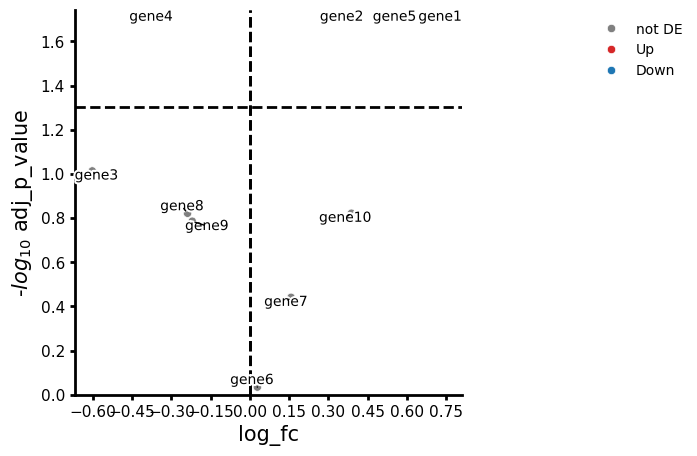

In [8]:
edgr.plot_volcano(res_df, log2fc_thresh=0)

## Pydeseq2

In [9]:
pds2 = pt.tl.PyDESeq2(adata=adata, design="~condition")
pds2.fit()
res_df = pds2.test_contrasts(["condition", "A", "B"])

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.05 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.03 seconds.



Log2 fold change & Wald test p-value: condition A vs B
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317       -0.632812  0.289101 -2.188898  0.028604  0.064150
gene2    21.281239       -0.538552  0.149963 -3.591236  0.000329  0.001646
gene3     5.010123        0.632830  0.295236  2.143476  0.032075  0.064150
gene4   100.517961        0.412102  0.118629  3.473868  0.000513  0.001710
gene5    27.142450       -0.582065  0.154706 -3.762409  0.000168  0.001646
gene6     5.413043       -0.001457  0.310311 -0.004696  0.996253  0.996253
gene7    28.294023       -0.134338  0.149945 -0.895917  0.370297  0.411441
gene8    40.358344        0.270656  0.136401  1.984261  0.047227  0.078711
gene9    37.166183        0.212715  0.133243  1.596437  0.110391  0.143147
gene10   11.589325       -0.386011  0.244588 -1.578207  0.114518  0.143147


In [10]:
res_df

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,gene5,27.142450,-0.582065,0.154706,-3.762409,0.000168,0.001646,None
1,gene2,21.281239,-0.538552,0.149963,-3.591236,0.000329,0.001646,None
2,gene4,100.517961,0.412102,0.118629,3.473868,0.000513,0.001710,None
3,gene1,8.541317,-0.632812,0.289101,-2.188898,0.028604,0.064150,None
4,gene3,5.010123,0.632830,0.295236,2.143476,0.032075,0.064150,None
5,gene8,40.358344,0.270656,0.136401,1.984261,0.047227,0.078711,None
6,gene9,37.166183,0.212715,0.133243,1.596437,0.110391,0.143147,None
7,gene10,11.589325,-0.386011,0.244588,-1.578207,0.114518,0.143147,None
8,gene7,28.294023,-0.134338,0.149945,-0.895917,0.370297,0.411441,None
9,gene6,5.413043,-0.001457,0.310311,-0.004696,0.996253,0.996253,None


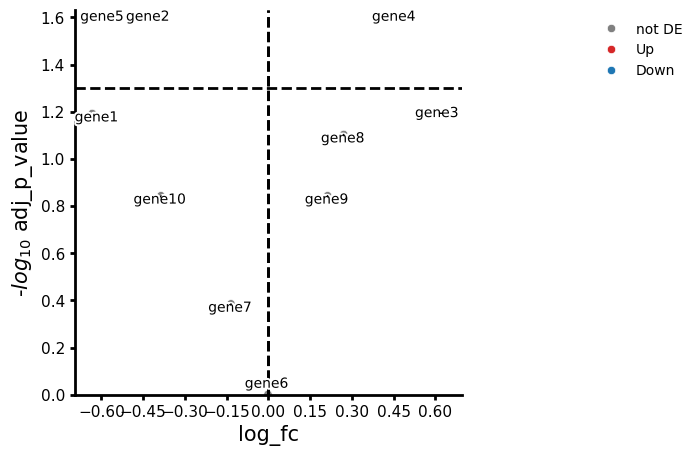

In [11]:
pds2.plot_volcano(res_df, log2fc_thresh=0)